In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [34]:
class SentientAnalizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size, embedding_dim):
        super(SentientAnalizer, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.Vocab_Embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.LSTM = nn.LSTM(self.embedding_dim, self.hidden_size,num_layers=2, batch_first=True)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.Linear2 = nn.Linear(self.hidden_size, self.output_size)


    def forward(self,x, hidden):
        emb = self.Vocab_Embedding(x).view(x.shape[0],x.shape[1],-1)
        #print (emb.shape)
        #print (hidden[0].shape)
        out, hidden = self.LSTM(emb, hidden)
        out = self.Linear1(out)
        out = torch.selu(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(2, batch_size, self.hidden_size),
                torch.zeros(2, batch_size, self.hidden_size))

In [35]:
class StockPredictor(nn.Module):

    def __init__(self, input_size_stock,input_size_sentiment, hidden_size, num_layers, max_length):
        super(StockPredictor, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size_stock = input_size_stock
        self.input_size_sentiment = input_size_sentiment
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attn_hidd = nn.Linear(self.input_size_stock, max_length)
        self.attn_out = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.CombinedLayerSS = nn.Linear(self.input_size_stock+self.input_size_sentiment, self.hidden_size)
        self.LSTM = nn.LSTM(self.input_size_sentiment+self.input_size_stock, self.hidden_size,num_layers=num_layers, batch_first=False)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        #self.dropout = nn.Dropout(0.1)
        self.Linear2 = nn.Linear(self.hidden_size, self.input_size_stock)


    def forward(self,x, hidden, stock_news):
        #print ("hidden:",hidden[0][0].shape)
        attn_wights = F.softmax(self.attn_hidd(x), dim=1)
        #print (attn_wights.shape, stock_news.shape)
        context = torch.bmm(attn_wights, stock_news)
        #context = torch.einsum('ij,ijk->ik', attn_wights, stock_news)
        #print (context.shape, x.shape)
        x_SS = torch.cat((x,context),dim=2)
        out, hidden = self.LSTM(x_SS, hidden)
        out = self.Linear1(out)
        out = torch.selu(out)
        #out = self.dropout(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [36]:
news_1 = pd.read_csv('../data/Preprocess/final_data/Crypto_Currency_News.csv') # news_np[0]
news_2 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrencies.csv') # news_np[1]
news_3 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrency.csv') # news_np[2]
news_4 = pd.read_csv('../data/Preprocess/final_data/Cryptomarkets.csv') # news_np[3]
news_5 = pd.read_csv('../data/Preprocess/final_data/eth.csv') # news_np[4]
news_6 = pd.read_csv('../data/Preprocess/final_data/ethfinance.csv') # news_np[5]
news_7 = pd.read_csv('../data/Preprocess/final_data/ethtrader.csv') # news_np[6]

stocks_std = pd.read_csv('../data/Preprocess/final_data/finance_std.csv')


news_dfs = [news_1, news_2, news_3, news_4, news_5, news_6, news_7]
col_names = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']

# # import scaler
# with open('../data/Preprocess/scaler.pkl', 'rb') as f:
#     scaler = pkl.load(f)
'''
example of cell in news_1:
'[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]'
is saved as a string
'''
# change type
import ast
for df in news_dfs:
    for j in range(1,11):        
        df['tok_text_'+str(j)] = np.array(df['tok_text_'+str(j)].apply(lambda x: ast.literal_eval (x)))

In [37]:
# convert all dataframes to numpy
# news_1_np = news_1.to_numpy()
news_np = []
for df in news_dfs:
    news_np.append(df.to_numpy())

stocks_norm_np = stocks_std.to_numpy()

# delete 1st column
# news_1_np = news_1_np[:,1:]
for i in range(len(news_np)):
    news_np[i] = np.delete(news_np[i], 0, 1)
stocks_norm_np = stocks_norm_np[:,1:]

# reshape from (n,10) lists to (n,10,15) numbers
for k in range(len(news_np)):
    news_np[k] = np.array([np.array([np.array(news_np[k][i][j]) for j in range(10)]) for i in range(news_np[k].shape[0])])

# print
for i in range(len(news_np)):
    print(news_np[i].shape)
print (stocks_norm_np.shape)
# print first row, already checked it is the first row from the CSVs
# print (news_np[0][0])
# print(stocks_norm_np[0])

(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 9)


In [38]:
# shape dataset to pytorch dataset class    
class Dataset (torch.utils.data.Dataset):
    def __init__(self, data_stock, notice, target):
        self.data = data_stock.unsqueeze(1)
        self.notice = notice.unsqueeze(3)
        self.target = target.unsqueeze(1)
        # Standardize data
        self.data = (self.data - self.data.mean()) / self.data.std()
        self.target = (self.target - self.target.mean()) / self.target.std()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.notice[idx], self.target[idx]

# split dataset into train and test
# using news_1 and stocks_norm, use all except one week, we will predict this week in testing
# data_stock = torch.Tensor(stocks_norm_np[:,:]).float()
data_stock = torch.Tensor(stocks_norm_np[:-7,:].astype(np.float32))
test_stock = data_stock[-1] # we will start forcast from the real value of the last day of the train set
test_stock = test_stock.unsqueeze(0).unsqueeze(0)
# data_news = torch.Tensor(news_np[0]).long() 
data_news = torch.Tensor(news_np[0][:-7,:,:]).long() # news_np[0] is news_1 (Crypto_Currency_News.csv), change to others as needed
target = data_stock[1:,:]
data_stock = data_stock[:-1,:]
print (data_stock.shape, data_news.shape, target.shape)

# create dataset
dataset = Dataset(data_stock, data_news, target)

torch.Size([1088, 9]) torch.Size([1089, 10, 15]) torch.Size([1088, 9])


In [39]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
Senti = SentientAnalizer(1, 128, 256, 50000, 128) # .to(device) # 50000 is the size of the vocabulary, our dictionary has 49783 words
Stock = StockPredictor(9,256,256,4,10) # .to(device) # 9 is the number of variables in the stock

In [41]:
# dataloader
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [42]:
# optimizer
optimizer = torch.optim.Adam(list(Senti.parameters())+list(Stock.parameters()), lr=0.001) # lr=0.001
# loss function
criterion = nn.MSELoss()
# clip gradient
clip = .5

In [43]:
# train

future = 50
for epoch in range(140):
    
    
    #hidde_stock = (hidde_stock[0][:,:-future], hidde_stock[1][:,:-future])
    tot_loss = 0
    mean_loss = 0
    Progressbar = tqdm(train_loader)
    for i, (data_stock,data_news,target) in enumerate(Progressbar):
        #print (data_stock.shape, data_news.shape, target.shape)
        hidde_senti = Senti.init_hidden(10)
        hidde_senti = (hidde_senti[0], hidde_senti[1]) # (hidde_senti[0].to(device), hidde_senti[1].to(device))
        hidde_stock = Stock.init_hidden(batch_size=1)
        hidde_stock = (hidde_stock[0], hidde_stock[1]) # (hidde_stock[0].to(device), hidde_stock[1].to(device))
        data_stock = data_stock
        data_news = data_news
        target = target
        senti_outputs = []
        stock_outputs = []
        for batch in data_news:
            senti_output, hidden_senti = Senti(batch.squeeze(0), hidde_senti)
            senti_outputs.append(senti_output[:,-1,:])
        senti_outputs = torch.cat(senti_outputs, dim=0)    
        senti_outputs = senti_outputs.reshape(len(data_stock),10,256)
        #print (data_stock.shape)
        #print (senti_outputs.shape)
        #print (hidde_stock[0].shape)
        #print (hidde_stock[1].shape)
        data_stock = data_stock[:-future]
        stock_output, hidde_stock = Stock(data_stock, hidde_stock, senti_outputs[:-future])
        #print ("output",stock_output.shape)
        output = stock_output[-1,:,:]
        senti = senti_outputs[-future,:,:]
        #print (output.shape)
        #print (hidde_stock[0].shape)
        for i in range(future):
            #print ("Sizes:",output.shape, senti.shape, hidde_stock[0].shape)
            output, hidde_stock = Stock(output.unsqueeze(0), hidde_stock, senti.unsqueeze(0))
            stock_outputs.append(output)
            output = output.squeeze(0)
            #print (output.shape)
        stock_outputs = torch.cat(stock_outputs, dim=0)
        # cat stock_output and stock_outputs
        stock_output = torch.cat((stock_output, stock_outputs), dim=0)
        #print (stock_output.shape)
        loss = criterion(stock_output, target)
        mean_loss += loss
        Progressbar.set_description("Epoch: {}, Loss: {}".format(epoch, mean_loss.item()/len(train_loader)))
    mean_loss = mean_loss/len(train_loader)
    mean_loss = mean_loss #.cpu()
    optimizer.zero_grad()
    mean_loss.backward()
    torch.nn.utils.clip_grad_norm_(list(Senti.parameters())+list(Stock.parameters()), clip)
    optimizer.step()
    if (epoch+1)%4 == 0:
        print ("Epoch: {}/{}...".format(epoch+1, 50),
               "Loss: {:.6f}...".format(mean_loss.item()))
        

Epoch: 3, Loss: 0.8823005676269531: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it] 


Epoch: 4/50... Loss: 0.882301...


Epoch: 7, Loss: 1.1042984008789063: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it] 


Epoch: 8/50... Loss: 1.104298...


Epoch: 11, Loss: 0.7436850547790528: 100%|██████████| 5/5 [00:18<00:00,  3.66s/it] 


Epoch: 12/50... Loss: 0.743685...


Epoch: 15, Loss: 0.7979344367980957: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it] 


Epoch: 16/50... Loss: 0.797934...


Epoch: 19, Loss: 0.5361372947692871: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]  


Epoch: 20/50... Loss: 0.536137...


Epoch: 23, Loss: 0.5225425243377686: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it] 


Epoch: 24/50... Loss: 0.522543...


Epoch: 27, Loss: 0.7853829383850097: 100%|██████████| 5/5 [00:19<00:00,  3.96s/it] 


Epoch: 28/50... Loss: 0.785383...


Epoch: 31, Loss: 0.4838459014892578: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it] 


Epoch: 32/50... Loss: 0.483846...


Epoch: 35, Loss: 0.4568295955657959: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it] 


Epoch: 36/50... Loss: 0.456830...


Epoch: 39, Loss: 0.4468088150024414: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it] 


Epoch: 40/50... Loss: 0.446809...


Epoch: 43, Loss: 0.5085319519042969: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]  


Epoch: 44/50... Loss: 0.508532...


Epoch: 47, Loss: 0.44814586639404297: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Epoch: 48/50... Loss: 0.448146...


Epoch: 49, Loss: 0.43811583518981934: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


In [34]:
# Save model
torch.save(Senti.state_dict(), 'Sentib.pt')
torch.save(Stock.state_dict(), 'Stockb.pt')

In [89]:
# Load model
Senti.load_state_dict(torch.load('saved_m_forecast/Senti3.pt', map_location=torch.device('cpu')))
Stock.load_state_dict(torch.load('saved_m_forecast/Stock3.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [96]:
# test with forecast
with torch.no_grad():
    count  = 0
    for batch in train_loader:
        batch = batch
        
        if count == 4:
            
            print ("tamaño:",batch[0].shape)
            break
        count += 1

    data_stock = batch[0] #.to(device)
    data_news = batch[1] #.to(device)
    target = batch[2] #.to(device)
    hidde_senti = Senti.init_hidden(10)
    hidde_senti = (hidde_senti[0], hidde_senti[1]) # (hidde_senti[0].to(device), hidde_senti[1].to(device))
    hidde_stock = Stock.init_hidden(batch_size=1)
    hidde_stock = (hidde_stock[0], hidde_stock[1]) # (hidde_stock[0].to(device), hidde_stock[1].to(device)) 
    senti_outputs = []
    stock_outputs = []
    for batch in data_news:
        senti_output, hidden_senti = Senti(batch.squeeze(0), hidde_senti)
        senti_outputs.append(senti_output[:,-1,:])
    senti_outputs = torch.cat(senti_outputs, dim=0)
    senti_outputs = senti_outputs.reshape(len(data_stock),10,256)
    data_stock = data_stock[:-future]
    stock_output, hidde_stock = Stock(data_stock, hidde_stock, senti_outputs[:-future])
    output = stock_output[-1,:,:]
    senti = senti_outputs[-future,:,:]
    for i in range(future):
        output, hidde_stock = Stock(output.unsqueeze(0), hidde_stock, senti.unsqueeze(0))
        stock_outputs.append(output)
        output = output.squeeze(0)
    stock_outputs = torch.cat(stock_outputs, dim=0)
    stock_output = torch.cat((stock_output, stock_outputs), dim=0)
    print (stock_output.shape)
    print (target.shape)


tamaño: torch.Size([64, 1, 9])
torch.Size([64, 1, 9])
torch.Size([64, 1, 9])


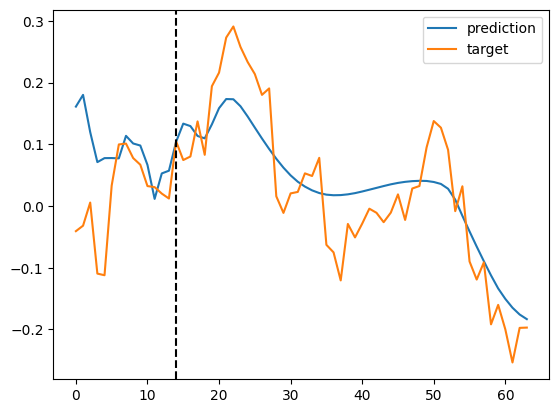

In [97]:
stock_output_np = np.array(stock_output.tolist())
target_np = np.array(target.tolist())
# plot the target vs the prediction
plt.plot(stock_output_np[:,0,0], label="prediction") 
plt.plot(target_np[:,0,0], label="target") 
# add a vertical line to indicate the end of the training data
plt.axvline(x=len(data_stock), color='k', linestyle='--')
plt.legend()
plt.show()